# Project 3 - Reddit APIs & Classification (Data pre-processing section)

## Background

Reddit is a massive collection of forums where people share news and content or comment on other people’s posts. Reddit is broken up into more than a million communities known as “subreddits” and each of which covers a different topic.

## Problem Statement

There are posts related to Pytorch and Tensorflow which could be wrongly posted in subreddits having similar content, and might require the moderators of the subreddits to clean it up occassionally to ensure content relevancy for viewers.

In this project, I aim to develop classifier models and identify if a Naive Bayes classifer or another classifier model would be suitable in classifying if a reddit post belongs to the either Pytorch or Tensorflow subreddits which can be useful for the moderators in deciding which posts that require cleanup.

## Executive Summary

The growing AI industry and the availability of open-sourced frameworks online such as the Tensorflow and Pytorch, the top 2 common frameworks used for implementing various neural network architecture by AI researchers, enthusiasts and application engineers has resulted in lots of questions and answers, especially in Reddit. 

As such there might be posts on Reddit site related to the two frameworks that could be wrongly posted in wrong subreddits. In view of the increasing amount of posts, it would be beneficial for subreddit stakeholders to have a classifier that helps to classify related posts/comments which are posted incorrectly in various subreddits as part of their cleanup process.

In this project, more than 900 reddit posts have been scraped from both Pytorch and Tensorflow subreddits respectively via Reddit's API, for the purpose of training classifier models which could potentially recommend Reddit moderators if a specific post should be moved to correct subreddit.

# Implementation

## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import regex as re

from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
# Uncomment the nextline and download stopwords if there isn't one in your computer. Import stopwords when done.
# nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# fontsize of the tick labels
plt.rc('xtick', labelsize = 18)
plt.rc('ytick', labelsize = 18) 

## Define necessary functions for plotting and counting

In [2]:
def count_words(text):
    """
    This function takes in a string of text and count the number of words by splitting based on empty spaces.
    
    Argument:
    @text: python string
    """
    list_of_words = text.split(" ")
    return len(list_of_words)

def barplot_annotation(plots,dataframe_entries):
    """
    This function takes in plots and number of dataframe entries which annotates
    the number of instance for each patches(e.g bars for bar charts) in plot, as well as the percentage of instances in relation to
    number dataframe entries.
    Takes in the following argument:
    @plots: plots by matplotlib that was generated from subplot_histogram function below.
    @dataframe_entries: number of dataframe entries which plots are made on.
    """
    for p in plots.patches:
        #Format the annotation, 4 decimals for percentage and no decimal for barplot values.
        plots.annotate(f"{p.get_height():.0f}\n({100*(p.get_height()/dataframe_entries):,.1f}%)", 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       size=10,
                       xytext = (0, 12), 
                       textcoords = 'offset points')
        
def subplot_histograms(df1, df2, common_column, reddit_name = ["reddit 1", "reddit 2"], word_or_char = None):
    """
    This function generates a 1 by 2 subplots of histogram for the specific column of two provided dataframe.
    
    Argument:
    @df1: first pandas dataframe
    @df2: second pandas dataframe
    @common_column: name of column which is common for two dataframe for purpose of plot comparison
    @reddit_name: list of subreddit names to be used for labeling and title of plots. 
                Defaults to [reddit 1, reddit 2] list.
    @word_or_char: string to indicate what is measured.
    """
    
    if ((common_column not in df1.columns) or (common_column not in df2.columns)):
        raise ValueError("No such column exists in the dataframe")
    else:
        
        fig, ax = plt.subplots(nrows = 2, ncols = 1,figsize = (18,20)) 
        ax = ax.ravel() # Ravel turns a matrix into a vector
        
        #First plot for first dataframe
        ax[0].hist(df1[common_column], bins = 80) 
        # Set titles, labels, etc here for each subplot
        ax[0].set_title(f"Histogram plot of {word_or_char} counts for {reddit_name[0]} subreddit", fontsize = 24)
        ax[0].set_xlabel("Counts",fontsize = 20)
        ax[0].set_ylabel("Frequency counts",fontsize = 20)
        #barplot_annotation(ax[0],len(df1))
        
        #Second plot for first dataframe
        ax[1].hist(df2[common_column], color = 'orange', bins = 80)
        # Set titles, labels, etc here for each subplot
        ax[1].set_title(f"Histogram plot of {word_or_char} counts for {reddit_name[1]} subreddit", fontsize = 24)
        ax[1].set_xlabel(reddit_name[1],fontsize = 20)
        ax[1].set_ylabel("Frequency counts",fontsize = 20)
        #barplot_annotation(ax[1],len(df2))
        
        # Prevent subplot from overlapping each other
        plt.tight_layout()
    return None

def get_top_ngram(corpus_1, corpus_2, n=None ,reddit_name = ["reddit 1", "reddit 2"]):
    """
    This function plots the top 10 n-gram for each of the provided panda Series in a 2 by 1 subplot
    Argument:
    @corpus_1: Python series derived from a dataframe containing a corpus
    @corpus_2: Python series derived from a dataframe containing a corpus
    @n: number of grams to analyse
    @reddit_name: list of subreddit names to be used for title of plots. 
                Defaults to [reddit 1, reddit 2] list.
    """
    #Fit and transform the corpus and sum the words
    vec1 = CountVectorizer(ngram_range=(n, n)).fit(corpus_1)
    bag_of_words1 = vec1.transform(corpus_1)
    
    # Sum the number of entries of each n-gram 
    sum_words1 = bag_of_words1.sum(axis=0)
    
    # Generate a list of tuples to store the number of instances for each n-gram vocabulary using the 
    # value of vec.vocabulary_.items() which indicates the indexes of all n-grams(key of vec.vocabulary_.items()) fitted
    words_freq1 = [(word, sum_words1[0, idx]) 
                  for word, idx in vec1.vocabulary_.items()]
    
    # Sort in descending order regarding words frequencies
    words_freq1 = sorted(words_freq1, key = lambda x: x[1], reverse=True)
    
    # Repeat for second corpus
    vec2 = CountVectorizer(ngram_range=(n, n)).fit(corpus_2)
    bag_of_words2 = vec2.transform(corpus_2)
    
    # Sum the number of entries of each n-gram 
    sum_words2 = bag_of_words2.sum(axis=0)
    
    # Generate a list of tuples to store the number of instances for each n-gram vocabulary using the 
    # value of vec.vocabulary_.items() which indicates the indexes of all n-grams(key of vec.vocabulary_.items()) fitted
    words_freq2 = [(word, sum_words2[0, idx]) 
                  for word, idx in vec2.vocabulary_.items()]
    
    # Sort in descending order regarding words frequencies
    words_freq2 = sorted(words_freq2, key = lambda x: x[1], reverse=True)
    
    
    fig, ax = plt.subplots(nrows = 2, ncols = 1,figsize = (18,20)) 
    ax = ax.ravel() # Ravel turns a matrix into a vector
    
    # Take a list of top 10 n-grams
    top_number_to_show = 15
    ngrams1, counts1 = map(list,zip(*words_freq1[:top_number_to_show]))
    ngrams2, counts2 = map(list,zip(*words_freq2[:top_number_to_show]))
    
    #Plot a barplot and label the axes
    sns.barplot(x = counts1, y = ngrams1, ax = ax[0], color = "blue");
    ax[0].set_xlabel(f'Number of instances',fontsize = 20)
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[0].set_ylabel(f'Number of instances',fontsize = 20)
    ax[0].set_title(f'Plot of top {top_number_to_show} {n}-grams for {reddit_name[0]}',fontsize = 20)
    
    sns.barplot(x = counts2, y = ngrams2, ax = ax[1], color = "orange");
    ax[1].set_xlabel(f"Top {top_number_to_show} {n}-grams",fontsize = 20)
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].set_ylabel(f"Top {top_number_to_show} {n}-grams",fontsize = 20)
    ax[1].set_title(f'Plot of top {top_number_to_show} {n}-grams for {reddit_name[1]}',fontsize = 20)

    # Prevent subplot from overlapping each other
    plt.tight_layout()
    return None

## Read in the scraped data stored in csv

In [3]:
pytorch_df = pd.read_csv("./pytorch_posts.csv")
tf_df = pd.read_csv("./tf_posts.csv")

Check size of data

In [4]:
print(f"Size of pytorch subreddit: {pytorch_df.shape}")
print(f"Size of tensorflow subreddit: {tf_df.shape}")

Size of pytorch subreddit: (943, 115)
Size of tensorflow subreddit: (918, 115)


Get the information of these 2 dataframes

In [5]:
pytorch_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 115 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     943 non-null    int64  
 1   approved_at_utc                0 non-null      float64
 2   subreddit                      943 non-null    object 
 3   selftext                       713 non-null    object 
 4   author_fullname                924 non-null    object 
 5   saved                          943 non-null    bool   
 6   mod_reason_title               0 non-null      float64
 7   gilded                         943 non-null    int64  
 8   clicked                        943 non-null    bool   
 9   title                          943 non-null    object 
 10  link_flair_richtext            943 non-null    object 
 11  subreddit_name_prefixed        943 non-null    object 
 12  hidden                         943 non-null    bo

In [6]:
tf_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 115 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     918 non-null    int64  
 1   approved_at_utc                0 non-null      float64
 2   subreddit                      918 non-null    object 
 3   selftext                       711 non-null    object 
 4   author_fullname                910 non-null    object 
 5   saved                          918 non-null    bool   
 6   mod_reason_title               0 non-null      float64
 7   gilded                         918 non-null    int64  
 8   clicked                        918 non-null    bool   
 9   title                          918 non-null    object 
 10  link_flair_richtext            918 non-null    object 
 11  subreddit_name_prefixed        918 non-null    object 
 12  hidden                         918 non-null    bo

Check if all scraped post are unique by counting the unique utc values and compare against the number of entries

In [7]:
num_unique_posts_pt = pytorch_df["created_utc"].nunique()
num_unique_posts_tf = tf_df["created_utc"].nunique()

print(f"Number of unique Tensorflow data: {num_unique_posts_pt}")
print(f"Number of unique Tensorflow data: {num_unique_posts_tf}")

Number of unique Tensorflow data: 943
Number of unique Tensorflow data: 918


In [8]:
pytorch_df.head()

,Unnamed: 0,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,...,media,is_video,url_overridden_by_dest,crosspost_parent_list,crosspost_parent,media_metadata,is_gallery,gallery_data,poll_data,author_cakeday
0,0,NaN,pytorch,I have implemented ResNet-18 CNN from scatch i...,t2_2mmql89p,False,NaN,0,False,ResNet-18 from scratch,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,pytorch,I have trained [ResNet-18](https://github.com/...,t2_2mmql89p,False,NaN,0,False,ResNet-18 vs ResNet-34,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,pytorch,Open Neural Network Exchange (ONNX) is a power...,t2_40d0zt4s,False,NaN,0,False,Converting a model from Pytorch to Tensorflow:...,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,pytorch,"Hi,\n\nI'm considering a swap from TF 2.0 to P...",t2_6mbpx,False,NaN,0,False,Is there a flexible Dataloader similar to tf.d...,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,pytorch,I apologise in advanced for this newb question...,t2_9lo3x1bz,False,NaN,0,False,How to implement pre trained embeddings?,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Drop columns which have all nulls as it is not useful.

In [9]:
pytorch_df.dropna(axis = 1, how = 'all', inplace = True)
tf_df.dropna(axis = 1, how = 'all', inplace = True )

In [10]:
print(f"Size of pytorch subreddit: {pytorch_df.shape}")
print(f"Size of tensorflow subreddit: {tf_df.shape}")

Size of pytorch subreddit: (943, 88)
Size of tensorflow subreddit: (918, 91)


In [11]:
pytorch_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 88 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               943 non-null    int64  
 1   subreddit                943 non-null    object 
 2   selftext                 713 non-null    object 
 3   author_fullname          924 non-null    object 
 4   saved                    943 non-null    bool   
 5   gilded                   943 non-null    int64  
 6   clicked                  943 non-null    bool   
 7   title                    943 non-null    object 
 8   link_flair_richtext      943 non-null    object 
 9   subreddit_name_prefixed  943 non-null    object 
 10  hidden                   943 non-null    bool   
 11  pwls                     943 non-null    int64  
 12  downs                    943 non-null    int64  
 13  thumbnail_height         249 non-null    float64
 14  hide_score               9

In [12]:
tf_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 91 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   918 non-null    int64  
 1   subreddit                    918 non-null    object 
 2   selftext                     711 non-null    object 
 3   author_fullname              910 non-null    object 
 4   saved                        918 non-null    bool   
 5   gilded                       918 non-null    int64  
 6   clicked                      918 non-null    bool   
 7   title                        918 non-null    object 
 8   link_flair_richtext          918 non-null    object 
 9   subreddit_name_prefixed      918 non-null    object 
 10  hidden                       918 non-null    bool   
 11  pwls                         918 non-null    int64  
 12  downs                        918 non-null    int64  
 13  thumbnail_height    

## EDA

**The columns of interest for the dataframes would be *subreddit*, *selftext* and *title* as most of the remaining columns by are not relevant for our modelling**

In [13]:
columns_of_interest = ["created_utc","subreddit","selftext","title"]
pytorch_simplified = pytorch_df[columns_of_interest]
tf_simplified = tf_df[columns_of_interest]

**Check datatypes** 

In [14]:
print(pytorch_simplified.dtypes)
print(tf_simplified.dtypes)

created_utc    float64
subreddit       object
selftext        object
title           object
dtype: object
created_utc    float64
subreddit       object
selftext        object
title           object
dtype: object


In [15]:
pytorch_simplified.head()

,created_utc,subreddit,selftext,title
0,1.615279e+09,pytorch,I have implemented ResNet-18 CNN from scatch i...,ResNet-18 from scratch
1,1.615313e+09,pytorch,I have trained [ResNet-18](https://github.com/...,ResNet-18 vs ResNet-34
2,1.615205e+09,pytorch,Open Neural Network Exchange (ONNX) is a power...,Converting a model from Pytorch to Tensorflow:...
3,1.615189e+09,pytorch,"Hi,\n\nI'm considering a swap from TF 2.0 to P...",Is there a flexible Dataloader similar to tf.d...
4,1.615103e+09,pytorch,I apologise in advanced for this newb question...,How to implement pre trained embeddings?


**Check the entries of subreddit columns, ideally it should be consistent throughout since the data was scraped.**

In [16]:
print(pytorch_simplified["subreddit"].value_counts())
print()
print(tf_simplified["subreddit"].value_counts())

pytorch    943
Name: subreddit, dtype: int64

tensorflow    918
Name: subreddit, dtype: int64


**Fill null values with empty strings for all columns as they are all text and convert the entries in title and selftext to string prior to do word and character analysis**

In [17]:
tf_simplified = tf_simplified.fillna('')
pytorch_simplified = pytorch_simplified.fillna('')
tf_simplified[["selftext","title"]].apply(str)
pytorch_simplified[["selftext","title"]].apply(str)

selftext    0      I have implemented ResNet-18 CNN from s...
title       0                                 ResNet-18 fr...
dtype: object

**Clean up and lower case the words under *title* and *selftext* columns**

In [18]:
def processing_string(text):
    """
    Function to remove non-alphanumerics, stopwords while lowercasing the provided string contents 
    a string of words. It returns the processed string at the end of processing.
    
    Arguments:
    @text: String of words
    """
    
    # Remove non-letters. Keep contraction words
    letters_only = re.sub("[^a-zA-Z']", " ", text)
    # Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    return(" ".join([word for word in words]))

In [19]:
tf_simplified["selftext"] = tf_simplified["selftext"].apply(processing_string)
tf_simplified["title"] = tf_simplified["title"].apply(processing_string)
pytorch_simplified["selftext"] = pytorch_simplified["selftext"].apply(processing_string)
pytorch_simplified["title"] = pytorch_simplified["title"].apply(processing_string)

In [20]:
tf_simplified.head()

,created_utc,subreddit,selftext,title
0,1.586464e+09,tensorflow,you can discuss anything here that doesn't req...,the official feedback and discussion thread
1,1.594637e+09,tensorflow,a while back i made a post requesting the admi...,megathread tensorflow certification exam
2,1.615377e+09,tensorflow,,guide to tensorly a python library for tensor ...
3,1.615287e+09,tensorflow,,few experiments with neuro networks and sin x ...
4,1.615205e+09,tensorflow,open neural network exchange onnx is a powerfu...,converting a model from pytorch to tensorflow ...


### Word count and character count distributions of posts.
Check character and word counts of text for each subreddit by creating new columns respectively. Plotting the histogram of the new columns to check the distribution of counts.

**Character count**

In [21]:
tf_simplified['char_count_text'] = tf_simplified['selftext'].apply(lambda x: len(x))
pytorch_simplified['char_count_text'] = pytorch_simplified['selftext'].apply(lambda x: len(x))
tf_simplified['char_count_title'] = tf_simplified['title'].apply(lambda x: len(x))
pytorch_simplified['char_count_title'] = pytorch_simplified['title'].apply(lambda x: len(x))

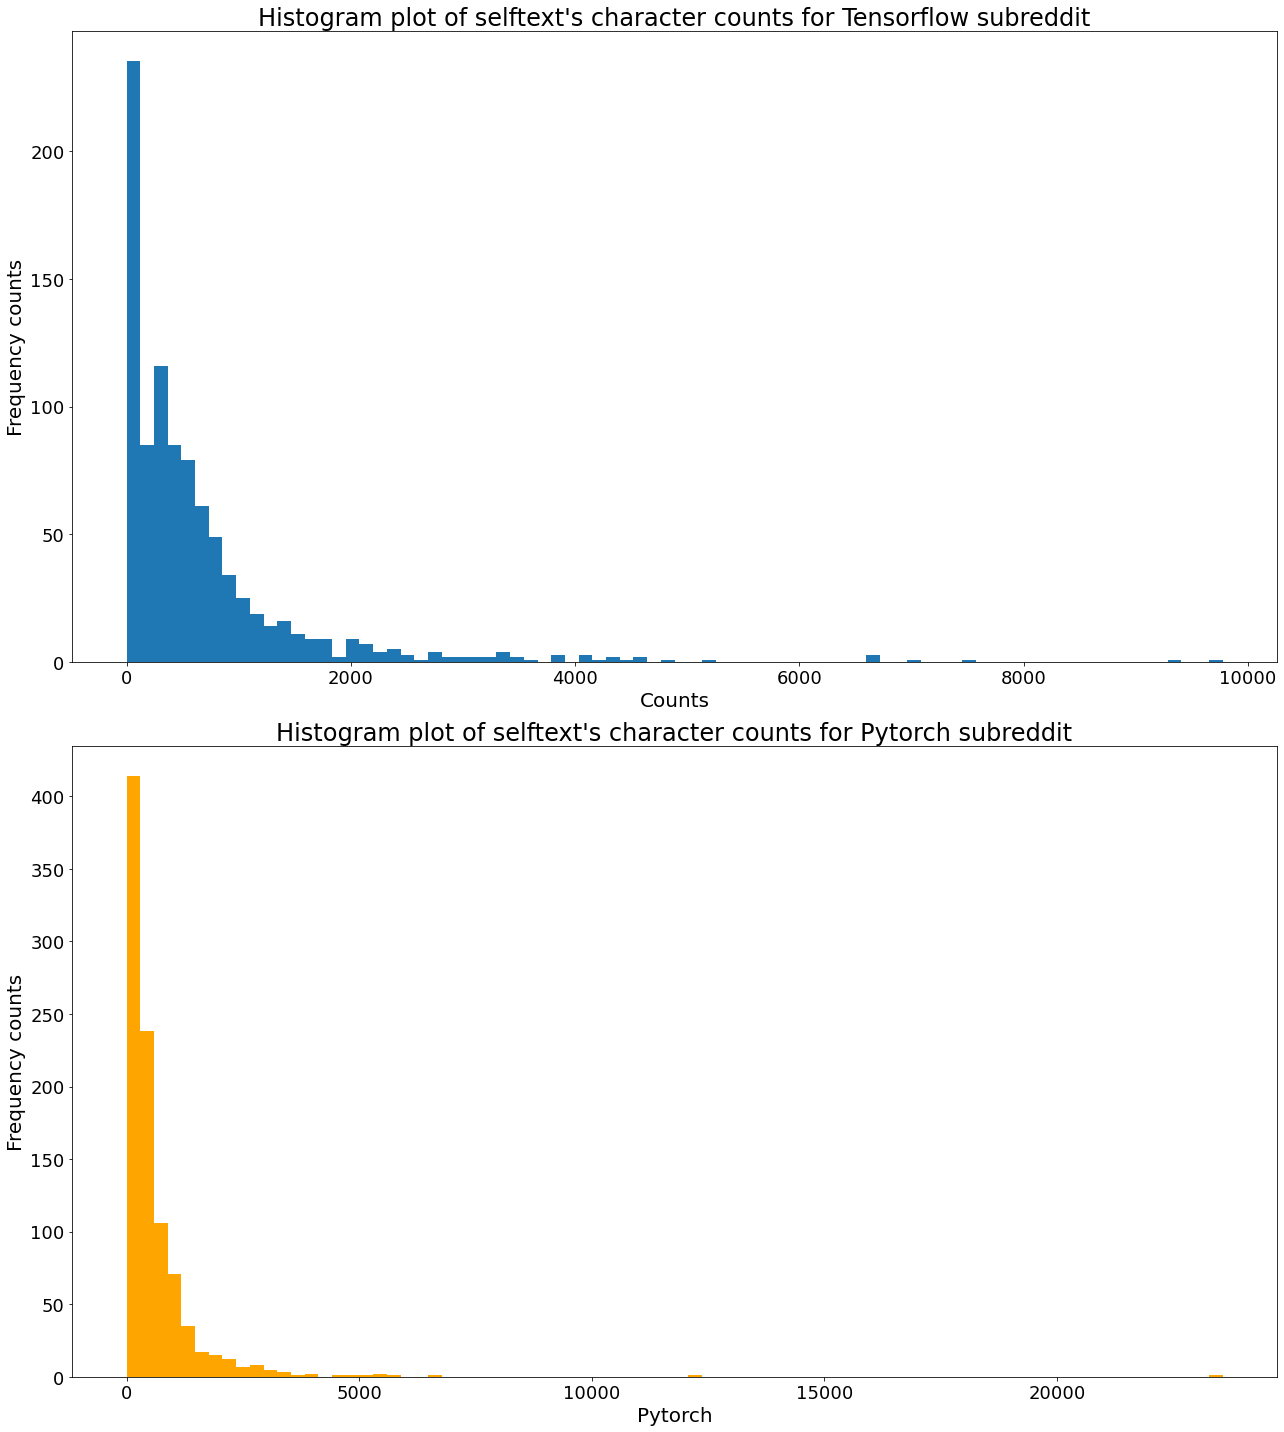

In [22]:
subplot_histograms(tf_simplified,
                   pytorch_simplified,
                   common_column="char_count_text",
                   reddit_name = ["Tensorflow","Pytorch"],
                   word_or_char = "selftext's character");

**KDE plot to estimate the distribution of character count for *selftext* column**

Text(0.5, 0, 'Character count')

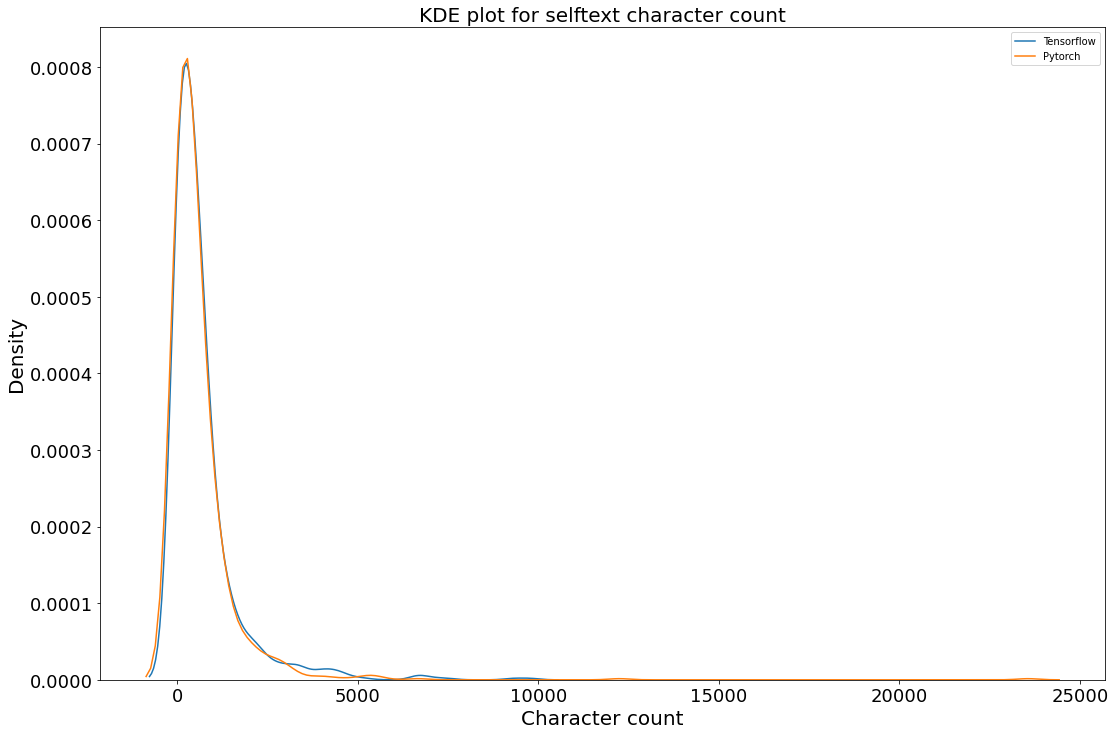

In [23]:
fig, ax  = plt.subplots(figsize = (18,12))
sns.kdeplot(tf_simplified["char_count_text"], ax = ax);
sns.kdeplot(pytorch_simplified["char_count_text"], ax = ax);
ax.legend(["Tensorflow","Pytorch"])
ax.set_title("KDE plot for selftext character count",fontsize = 20)
ax.set_ylabel("Density",fontsize = 20)
ax.set_xlabel("Character count",fontsize = 20)

**Word count**

In [24]:
tf_simplified['word_count_text'] = tf_simplified['selftext'].apply(lambda x: count_words(x))
pytorch_simplified['word_count_text'] = pytorch_simplified['selftext'].apply(lambda x: count_words(x))
tf_simplified['word_count_title'] = tf_simplified['title'].apply(lambda x: count_words(x))
pytorch_simplified['word_count_title'] = pytorch_simplified['title'].apply(lambda x: count_words(x))

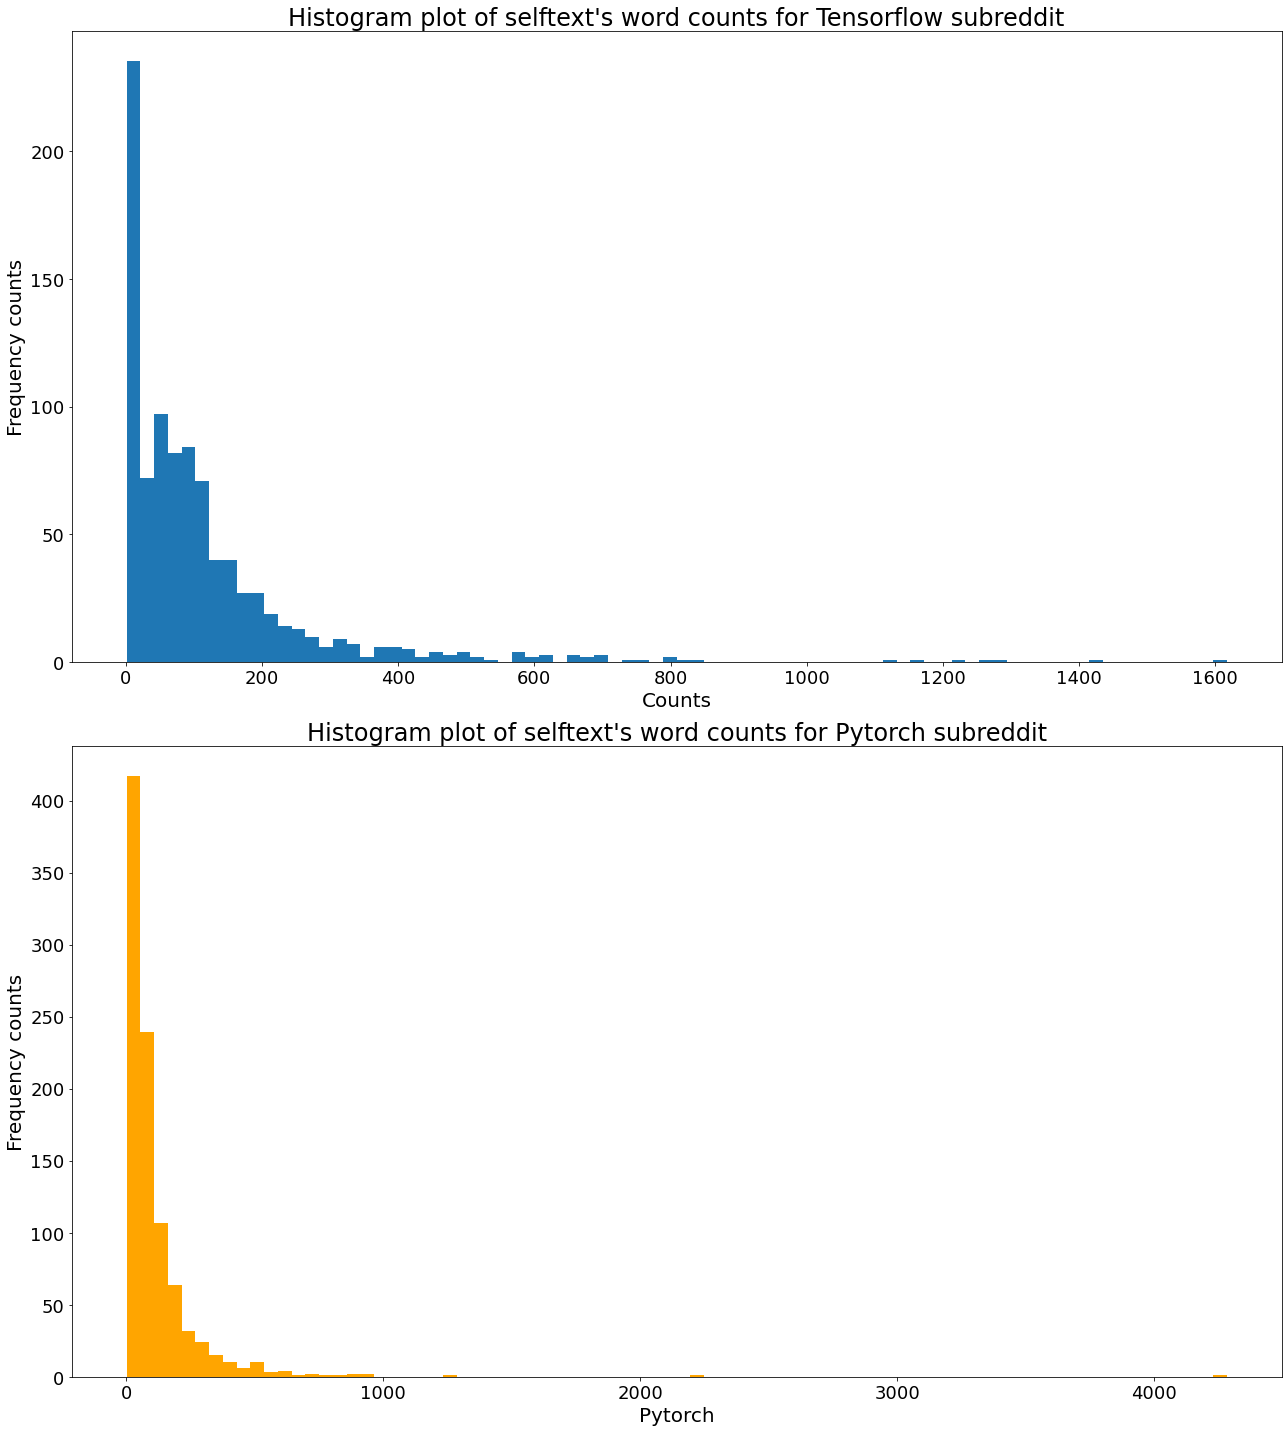

In [25]:
subplot_histograms(tf_simplified,
                   pytorch_simplified,
                   common_column="word_count_text",
                   reddit_name = ["Tensorflow","Pytorch"],
                   word_or_char = "selftext's word")

**KDE plot to estimate the distribution of character count for *selftext* column**

Text(0.5, 0, 'Word count')

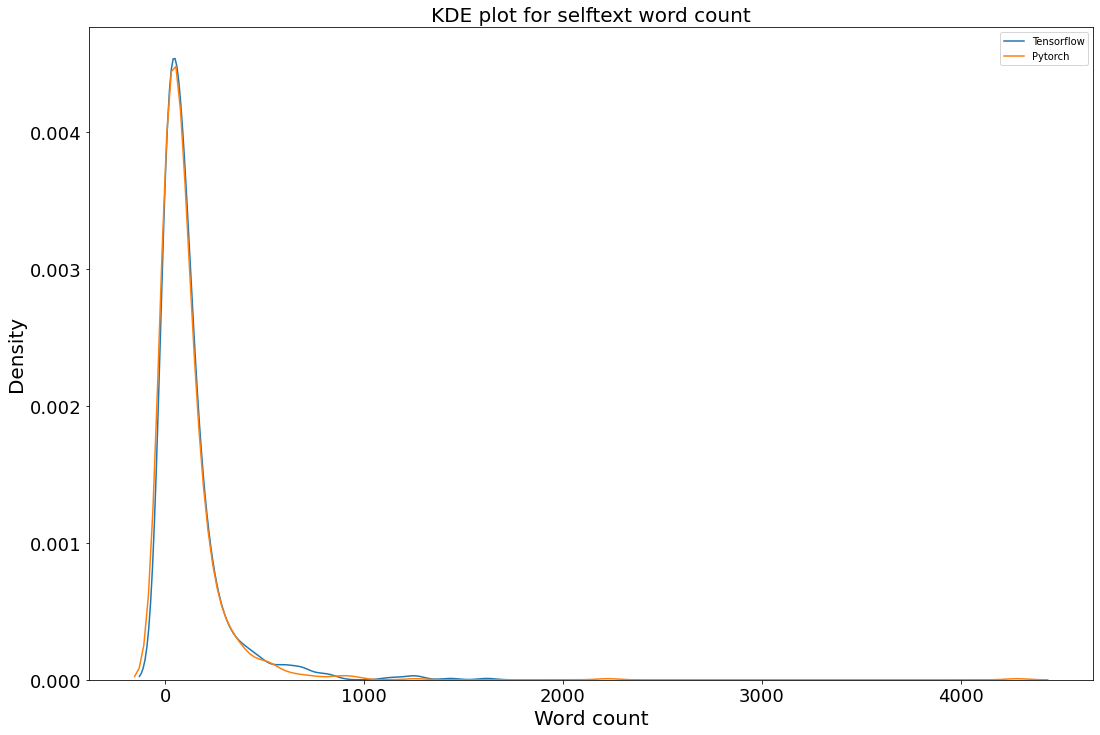

In [26]:
fig, ax  = plt.subplots(figsize = (18,12))
sns.kdeplot(tf_simplified["word_count_text"], ax = ax);
sns.kdeplot(pytorch_simplified["word_count_text"], ax = ax);
ax.legend(["Tensorflow","Pytorch"])
ax.set_title("KDE plot for selftext word count",fontsize = 20)
ax.set_ylabel("Density",fontsize = 20)
ax.set_xlabel("Word count",fontsize = 20)

### N-gram analysis
In this section, I try to plot out the most common n-grams in terms of frequencies to identify if there are common terms/words used for both subreddit posts, other than common words(stopwords) which could be added as stopwords as they are not useful in helping models to learn how to classify various subreddit posts.

A possible reason for the common occurrence for these terms is that both Pytorch and Tensorflow are deep learning frameworks which are open-sourced and furthermore, reddit is a platform where people would post things to ask questions or share their thoughts, expereience and knowledge. Hence, it is expected that url link sharing and words related to deep learning such as models would be common in both subreddits.

**Common unigram for Tensorflow and Pytorch seltext posts**

The common unigram selftext excluding stopwords that occurred: "https" and "model"

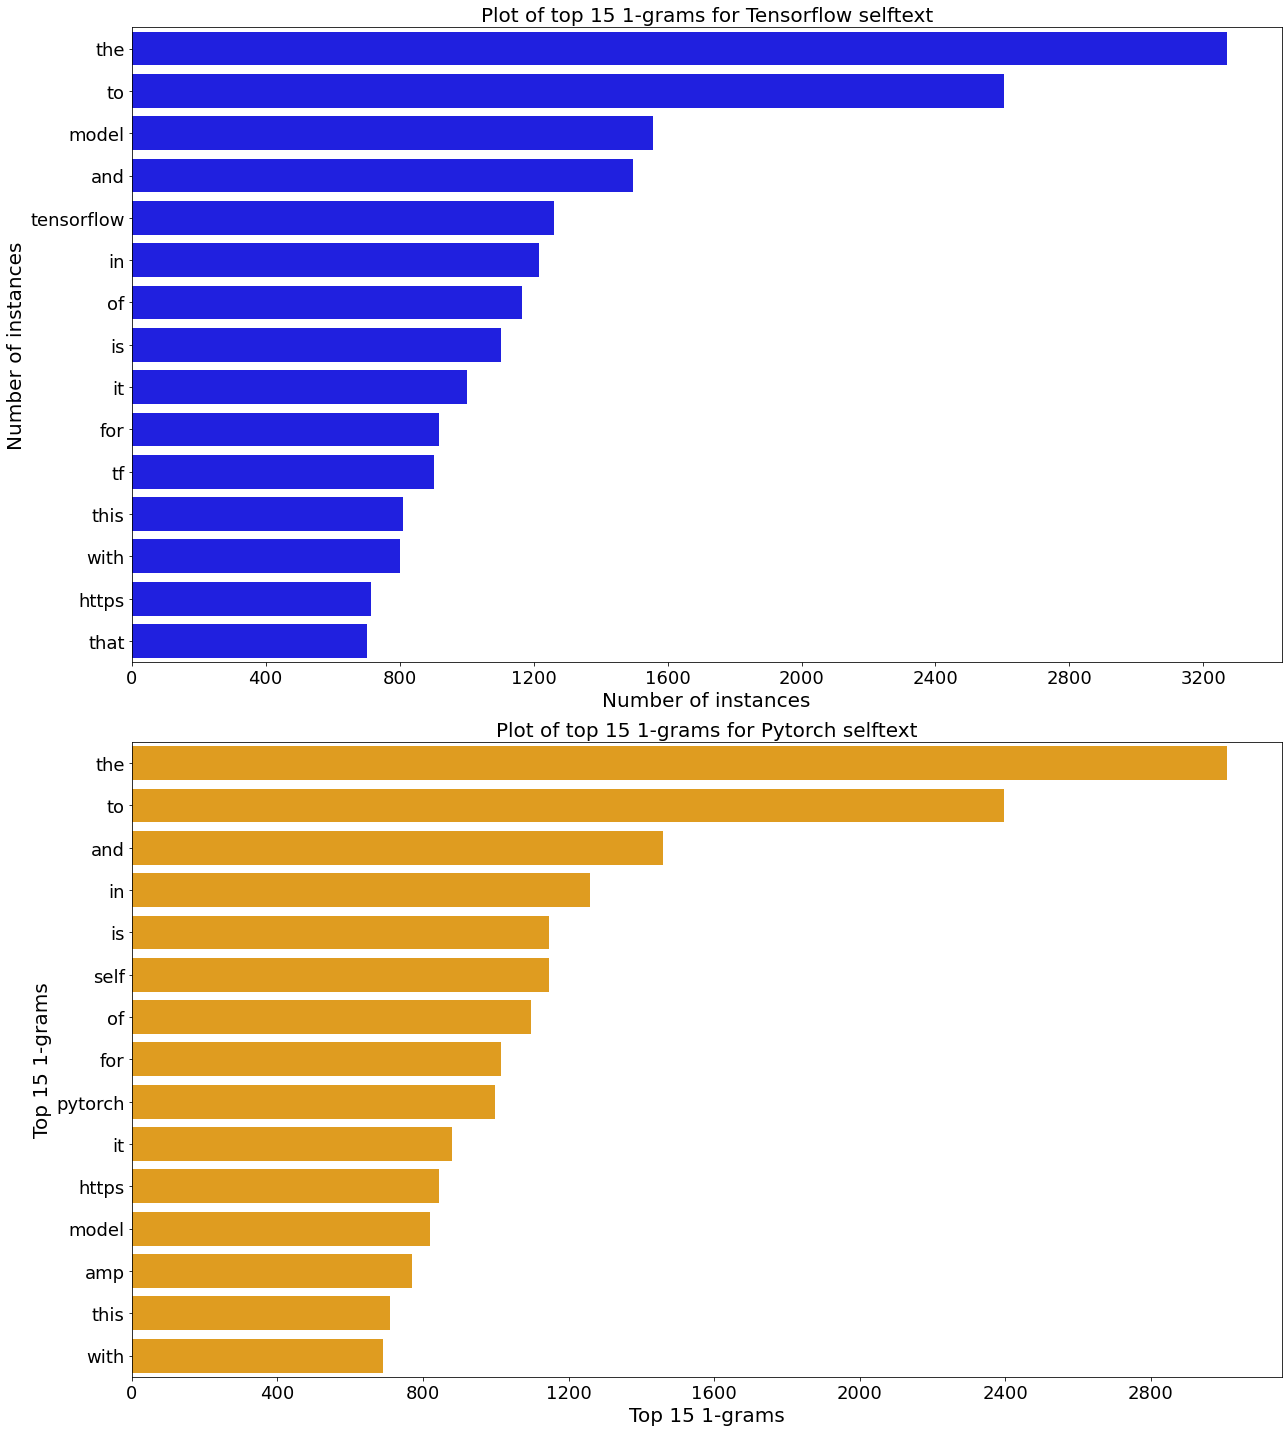

In [27]:
top_unigrams_tf_text = get_top_ngram(tf_simplified['selftext'],
                                      pytorch_simplified['selftext'],
                                      n = 1,
                                      reddit_name = ["Tensorflow selftext", "Pytorch selftext"]
                                    )

**Common unigram for Tensorflow and Pytorch title posts**

The common unigram title excluding stopwords that occurred: "model"

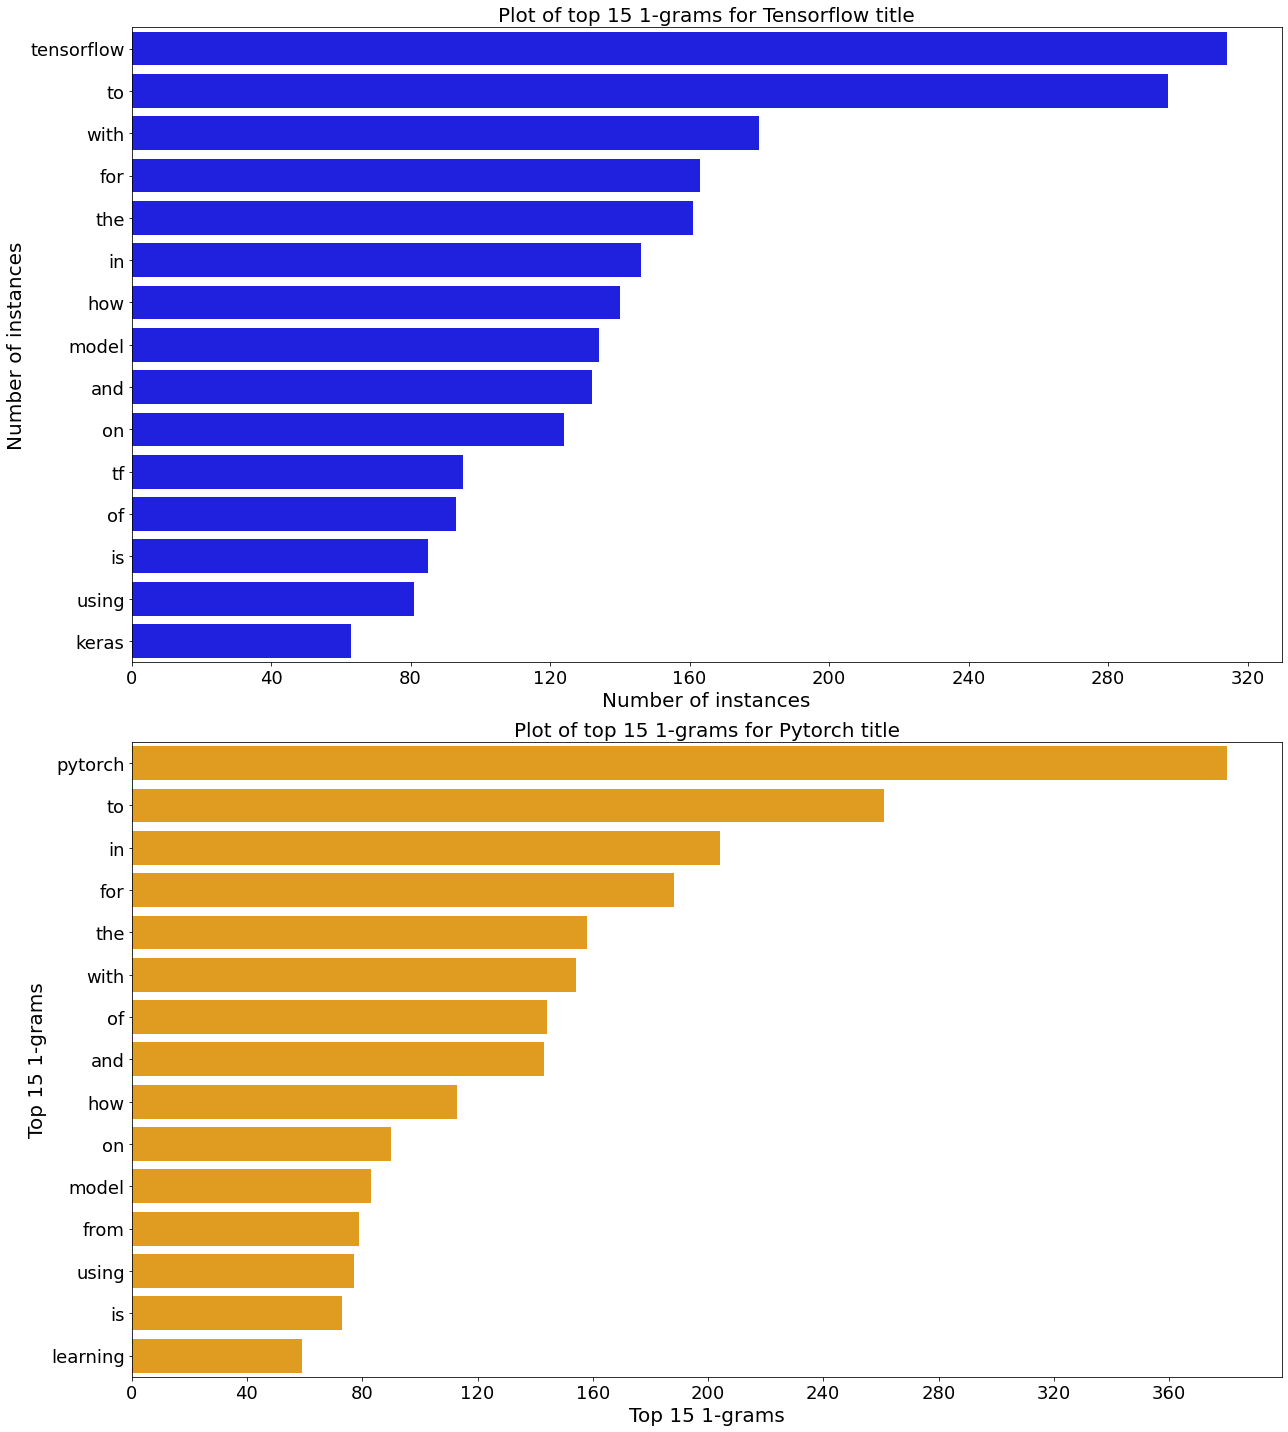

In [28]:
top_unigrams_tf_text = get_top_ngram(tf_simplified['title'],
                                      pytorch_simplified['title'],
                                      n = 1,
                                      reddit_name = ["Tensorflow title", "Pytorch title"]
                                      )

**Common bigram for Tensorflow and pytorch seltext posts**

The common bigram selftext that occurred: "https github" and "the model".

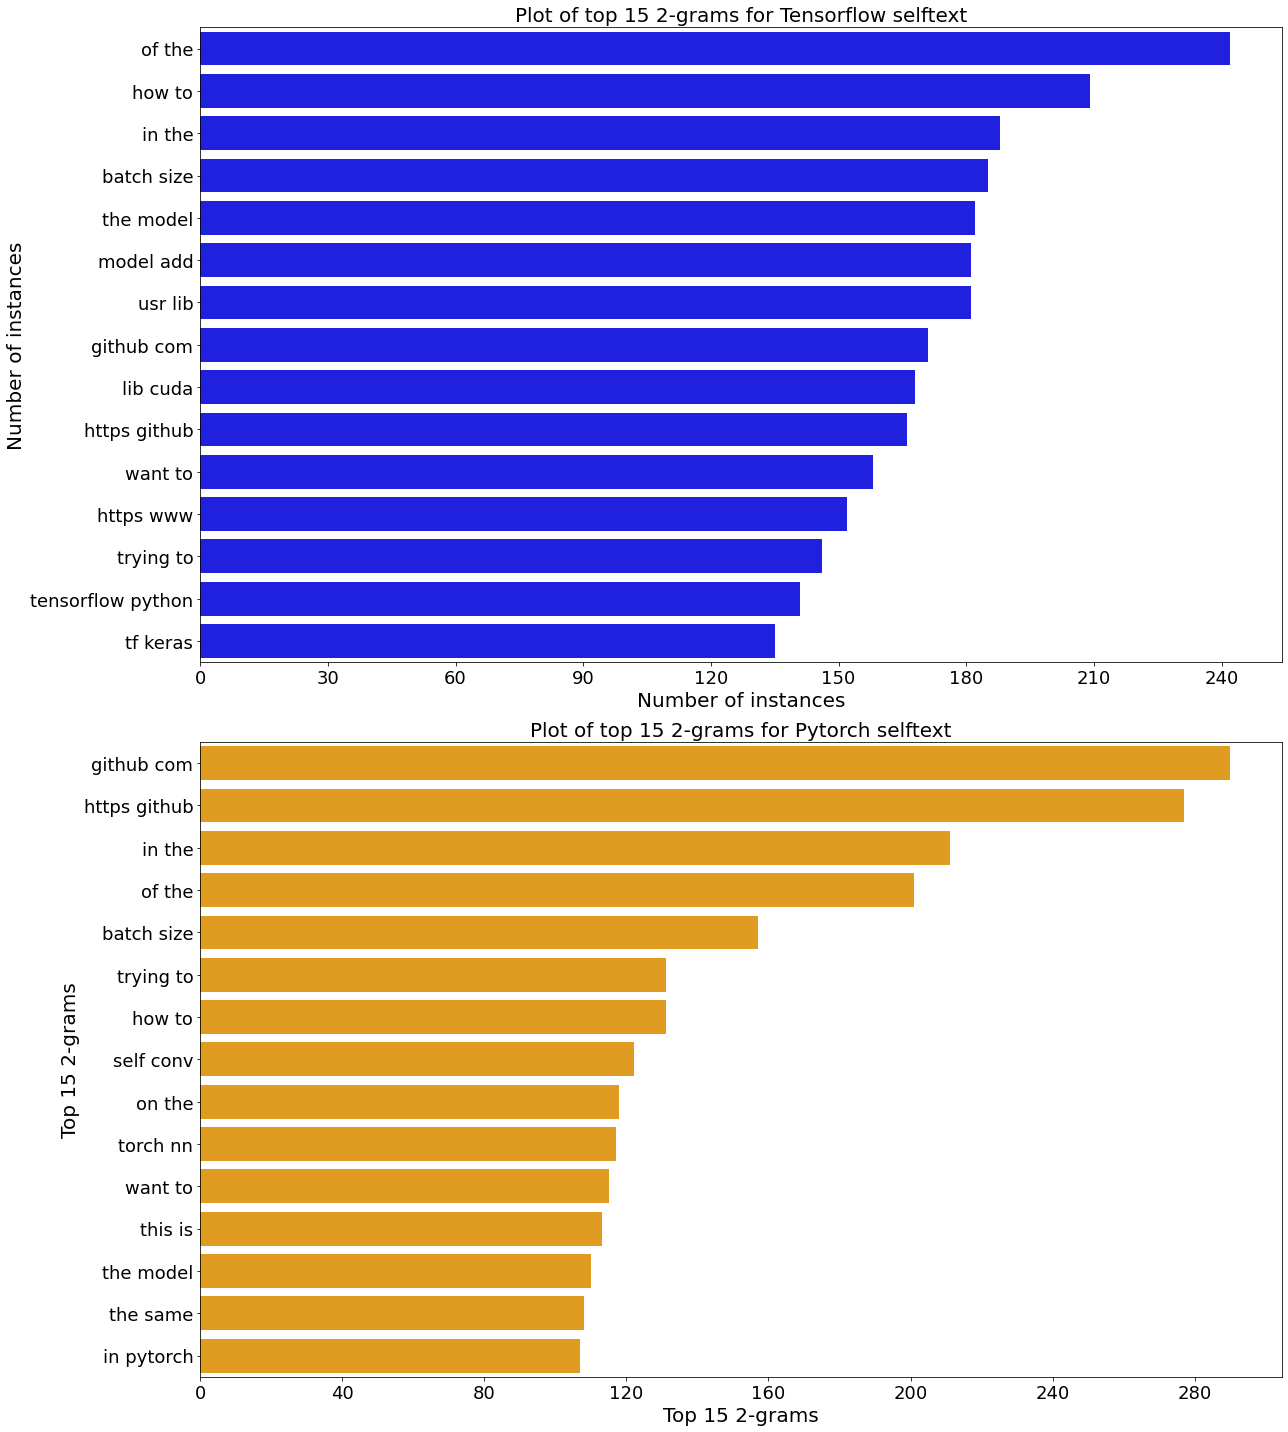

In [29]:
top_bigrams_tf_text = get_top_ngram(tf_simplified['selftext'],
                                      pytorch_simplified['selftext'],
                                      n = 2,
                                      reddit_name = ["Tensorflow selftext", "Pytorch selftext"]
                                      )

**Common bigram for Tensorflow and pytorch title posts**

The common bigram title that occurred: "machine learning".

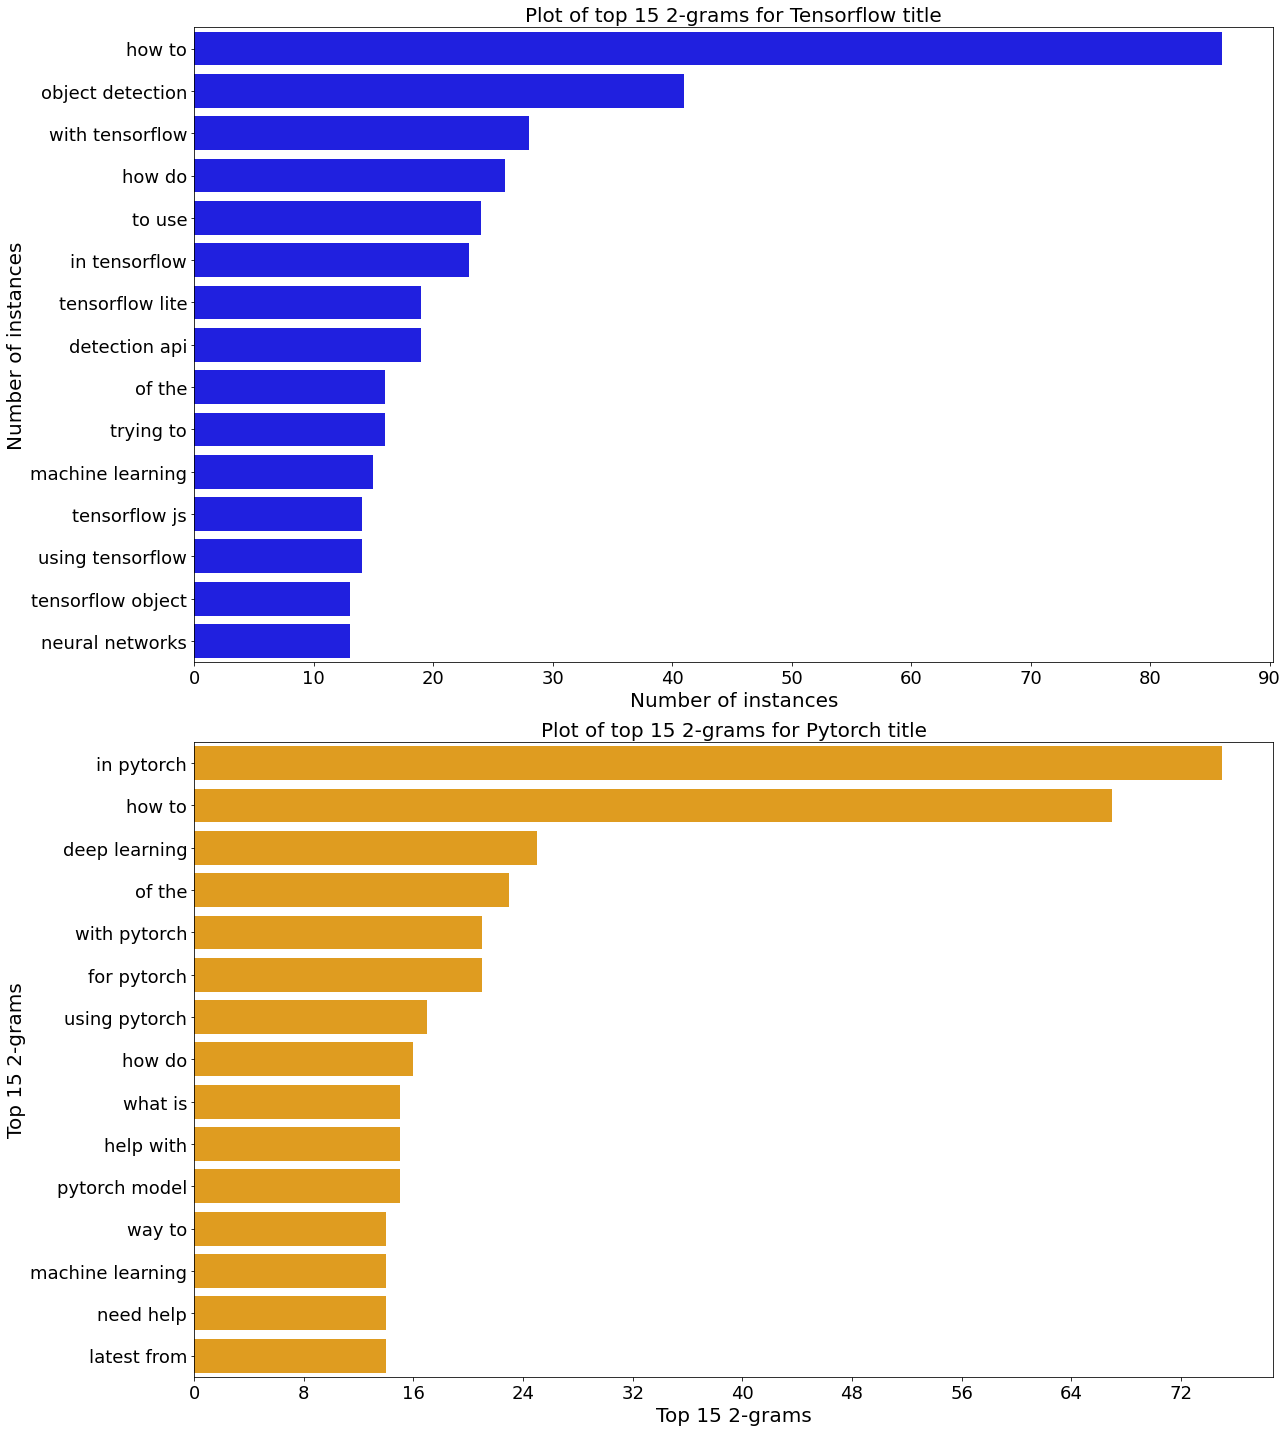

In [30]:
top_bigrams_tf_title = get_top_ngram(tf_simplified['title'],
                                      pytorch_simplified['title'],
                                      n = 2,
                                      reddit_name = ["Tensorflow title","Pytorch title"]
                                      )

**Common trigram for Tensorflow and pytorch selftext posts**

The common trigram title that occurred: "https github com".

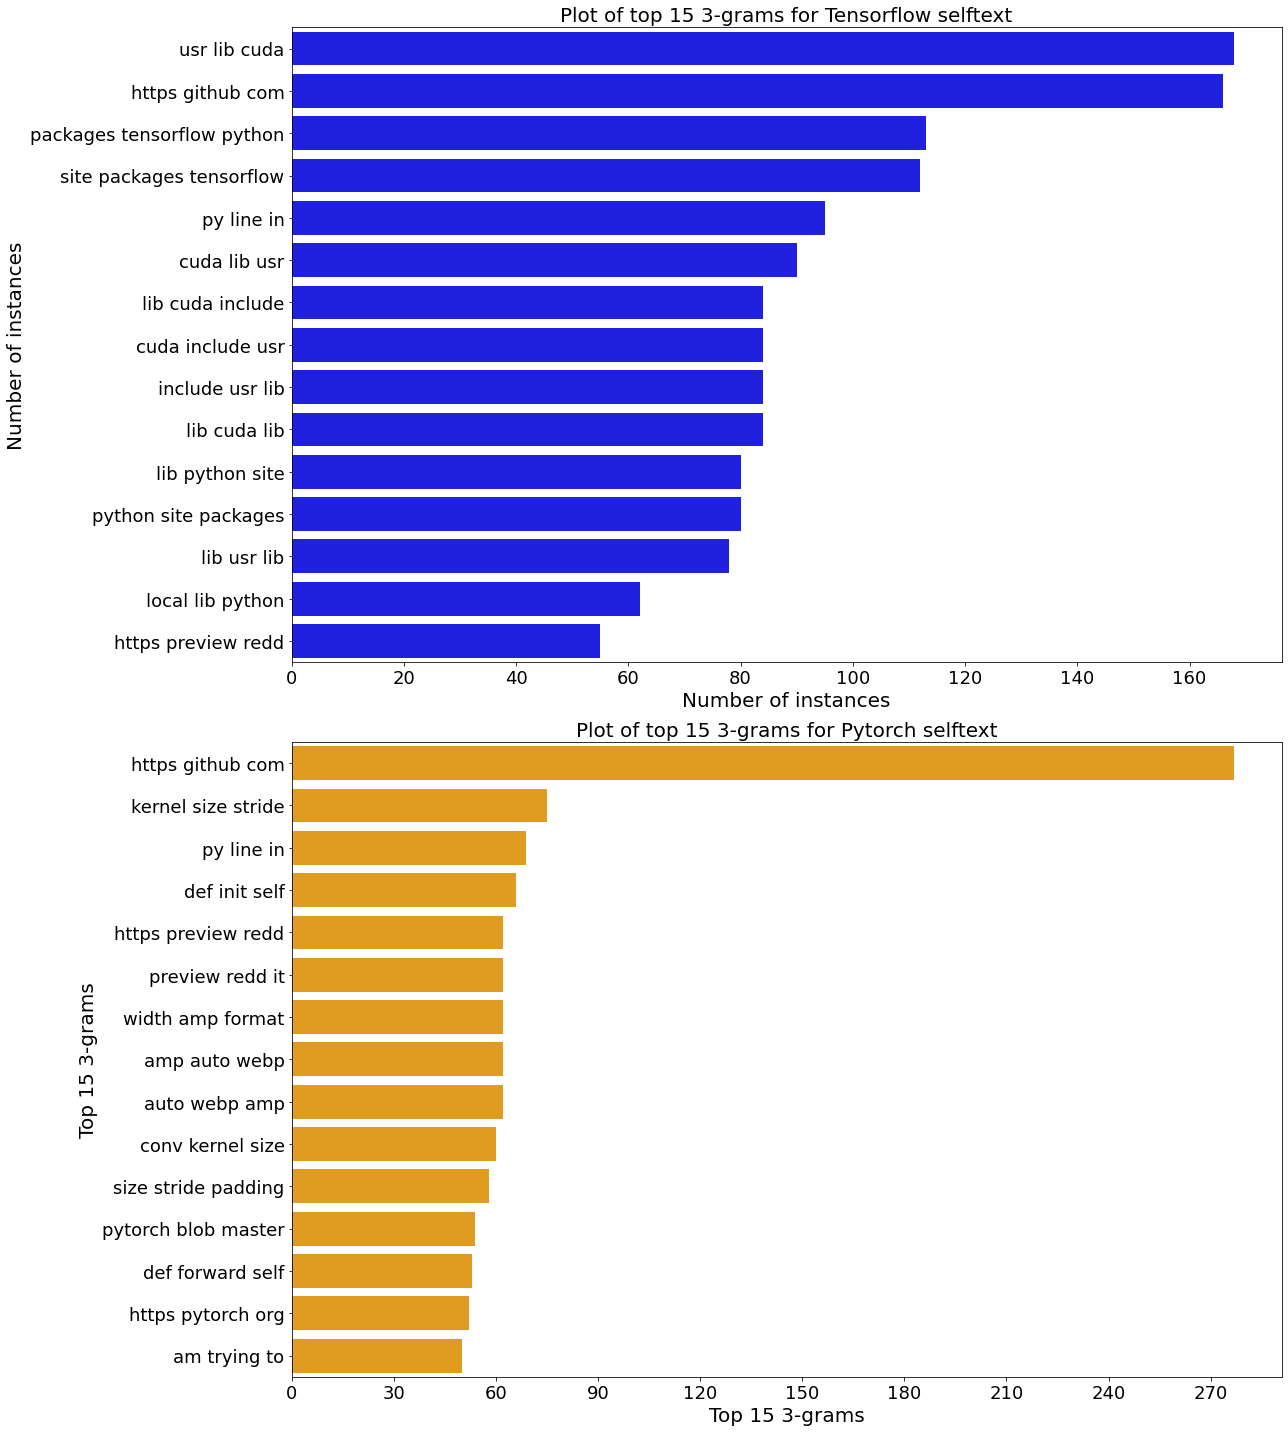

In [31]:
top_tri_grams_tf_title = get_top_ngram(tf_simplified['selftext'],
                                      pytorch_simplified['selftext'],
                                      n = 3,
                                      reddit_name = ["Tensorflow selftext","Pytorch selftext"]
                                      )

**Common trigram for Tensorflow and pytorch title posts**

The common trigram title that occurred: "of the art".

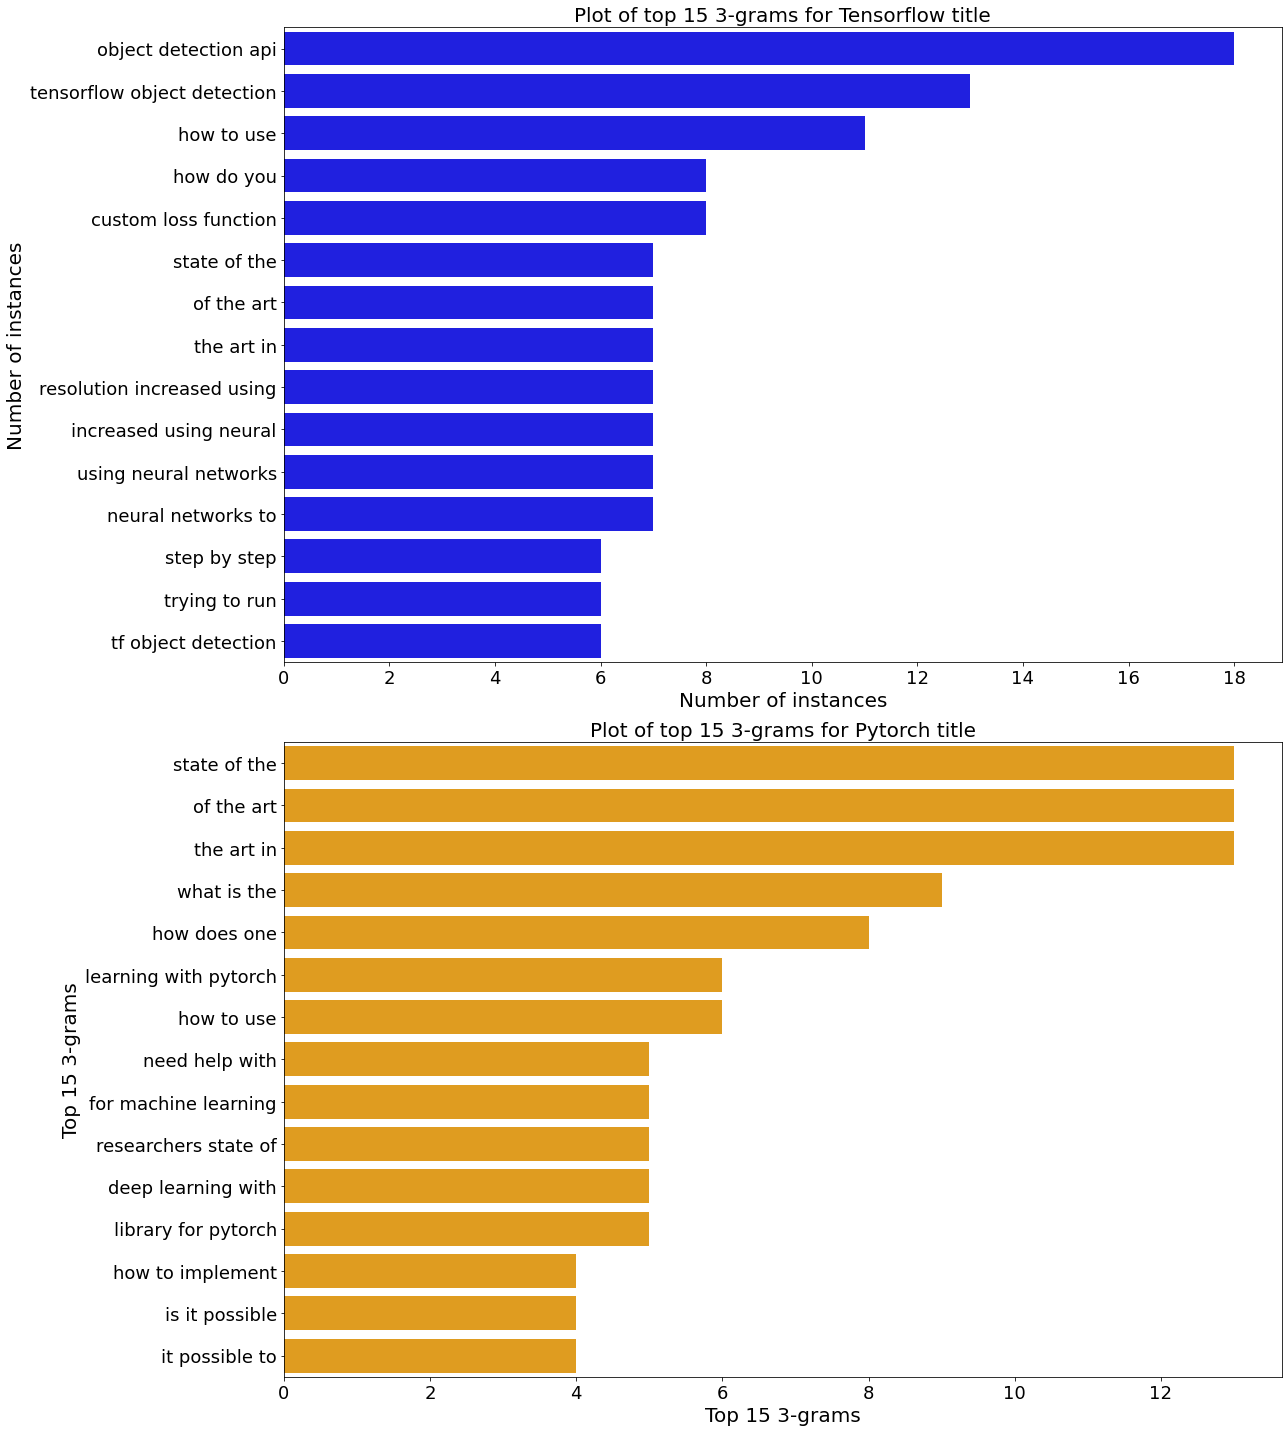

In [32]:
top_tri_grams_tf_title = get_top_ngram(tf_simplified['title'],
                                      pytorch_simplified['title'],
                                      n = 3,
                                      reddit_name = ["Tensorflow title","Pytorch title"]
                                      )

### Dataframe concatenation
Concatenate two dataframes to facilitate further processing.
**Relabel the subreddit column entries with "1" representing tensorflow and "0" representing pytorch to facilitate for model training.**

Combine the contents in *title* and *selftext* columns for easier processing since there are posts which are non-text, possibly images or non text, which in our case the only useful information in NLP would be the just the *title* column itself.

In [33]:
df = pd.concat([pytorch_simplified, tf_simplified])
df['subreddit'] = df['subreddit'].map(lambda x: 1 if x == 'tensorflow' else 0)
df["title_text"] = df["title"] + " " + df["selftext"]

### Tokenization, Lemmatizing/Stemming and removal of stopwords

I will include a list of additional words to be added to a list of english stopwords as they are found commonly in both subreddit of interest.

In [34]:
additional_words = ["model", "https", "github", "batch", "size", "machine", "learning", "of", "the", "art"]

**WordNetLemmatizer**

In [35]:
def lemmatize_text(text, additional_words = additional_words):
    
    
    #Get words and aprostrophe
    words_apro_only = re.sub("[^a-zA-Z']", " ", text)
    
    words = words_apro_only.lower().split()
    
    lemmatize = [lemmatizer.lemmatize(w) for w in words]
    stops = set(stopwords.words('english'))
    
    # Add in given/default list of additional words to existing set of stopwords.
    stops.update(additional_words)
    
    #Filter away stop words and join the words back to a string
    meaningful_words = [word for word in lemmatize if word not in stops]
    return " ".join([word for word in meaningful_words])

# Instantiate lemmatizer.
lemmatizer = WordNetLemmatizer()
df["lemma_title_text"] = df["title_text"].apply(lemmatize_text)

**PorterStemmer**

In [36]:
p_stemmer = PorterStemmer()

def stemmer_text(text, additional_words = additional_words):
    #Get words and aprostrophe
    words_apro_only = re.sub("[^a-zA-Z']", " ", text)
    
    words = words_apro_only.lower().split()
    stemming = [p_stemmer.stem(w) for w in words]
    stops = set(stopwords.words('english'))
    
    # Add in given/default list of additional words to existing set of stopwords.
    stops.update(additional_words)
    
    #Filter away stop words and join the words back to a string
    meaningful_words = [word for word in stemming if word not in stops]
    
    #print(meaningful_words)
    return " ".join([word for word in meaningful_words])

df["pstem_title_text"] = df["title_text"].apply(stemmer_text)

### Save processed data into csv
Drop the character and word count columns

In [37]:
df.drop(["char_count_text","char_count_title","word_count_text","word_count_title"], axis = 1, inplace = True)
df.to_csv("pytorch_tf_reddit_concat.csv", index=False)